### Loading libraries and data

In [1]:
from jupyterthemes import jtplot

# Zastosowanie motywu jasnego do jupyter notebook. U mnie na laptopie działa tryb ciemny przez co np. nie widać nazw osi na rysunku
jtplot.style(theme='default', context='notebook', ticks=True, grid=False)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from termcolor import colored
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [2]:
#Importing data
data = pd.read_csv('atlas-higgs-challenge-2014-v2.csv.gz')

### Removing unnecessery data and assigning Labels

In [3]:
#Working on the copy so I wouldn't need to import data from folder every time i want to restart my code
df = data.copy()

#Removing unwanted columns
df.dropna(inplace = True)
df.drop(columns = ['KaggleSet', 'KaggleWeight', 'Weight', 'EventId'], inplace = True)

#Assigning 1 to signal and 0 to background
df['Label'] = df['Label']=='s'

### Creating test data with equal number of signal and background

In [4]:
#Separation of signal and background
signal = df[df['Label'] == 1]
background = df[df['Label'] == 0]

#Creating a samples with randomly chosen raws
signal_sample = signal.sample(n=5000, random_state=1)
background_sample = background.sample(n=5000, random_state=1)

#Creating column with Label and checking if it's 1 dimensional
y_signal = signal_sample['Label']
signal_sample.drop(columns = ['Label'], inplace = True)
if y_signal.ndim != 1:
    y_signal = np.reshape(y_signal, (-1,1))

y_background = background_sample['Label']
background_sample.drop(columns = ['Label'], inplace = True)
if y_background.ndim != 1:
    y_background = np.reshape(y_background, (-1,1))

#Creating training and test data sets
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(signal_sample, y_signal, test_size=0.2, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(background_sample, y_background, test_size=0.2, random_state=42)

#connecting previously created sets to ensure that I have equal amounts of signal and background
X_train = pd.concat([X_train_s, X_train_b], axis=0)
X_test = pd.concat([X_test_s, X_test_b], axis=0)
y_train = pd.concat([y_train_s, y_train_b], axis=0)
y_test = pd.concat([y_test_s, y_test_b], axis=0)

print(colored("Train labels shape:","red"), y_train.shape)
print(colored("Test labels shape:","blue"), y_test.shape)
print(colored("Train features shape:","red"), X_train.shape)
print(colored("Test features shape:","blue"), X_test.shape)

Train labels shape: (8000,)
Test labels shape: (2000,)
Train features shape: (8000, 30)
Test features shape: (2000, 30)


In [5]:
#Normalizing data sets
normalization = StandardScaler()
X_norm_train = normalization.fit_transform(X_train)
X_norm_test = normalization.transform(X_test)

### Training model

In [6]:
hidden_layer_sizes = (128, 128, 64)
model =  MLPClassifier(max_iter=500, hidden_layer_sizes = hidden_layer_sizes,
                       learning_rate = 'adaptive', learning_rate_init=0.001, activation='relu', 
                       solver='adam', random_state=42)

In [7]:
%%time
model.fit(X_norm_train, y_train)

#here model is training on smaller set of data. Bigger amount of data would ensure better accuracy 
#but it would also be very time consuming and this amount suffice to pass this homework
#On my computer creating this model took 12 minutes

CPU times: user 8min 23s, sys: 3min 37s, total: 12min
Wall time: 3min 5s


MLPClassifier(hidden_layer_sizes=(128, 128, 64), learning_rate='adaptive',
              max_iter=500, random_state=42)

### Checking working of the model

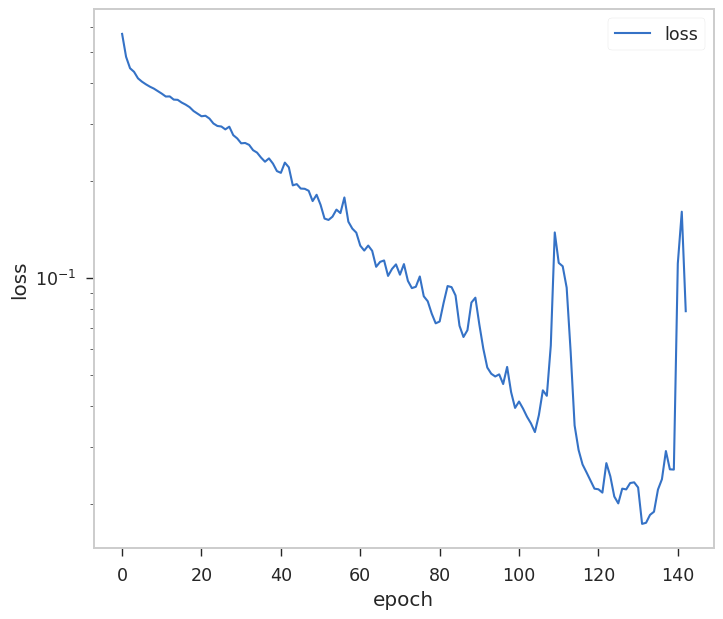

In [8]:
#Creating plot of loss history of my model
loss_history = model.loss_curve_
plt.plot(loss_history, label="loss")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')

In [9]:
#Obtaining predictions of the model
train_pred = model.predict(X_norm_train)
test_pred = model.predict(X_norm_test)

#Checking accuracy of the model 
train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print(f'training accuracy: {train_acc:0.2f}')
print(f'testing accuracy: {test_acc:0.2f}')

training accuracy: 0.99
testing accuracy: 0.76


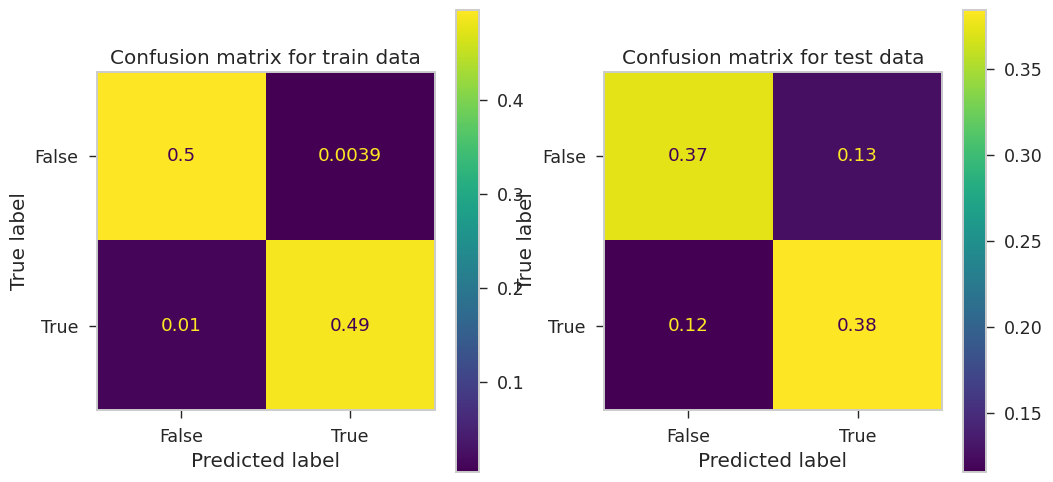

In [10]:
#Creating normalised confusion matrix
train_cm = confusion_matrix(y_train, train_pred)/len(y_train)
train_display = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=model.classes_)

test_cm = confusion_matrix(y_test, test_pred)/len(y_test)
test_display =ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=model.classes_)

fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].set_title("Confusion matrix for train data")
train_display.plot(ax=axes[0])
axes[1].set_title("Confusion matrix for test data")
test_display.plot(ax=axes[1])

plt.show()